# **DeepVision Crowd Monitor: AI for Density Estimation and Overcrowding Detection**

In [1]:
!pip install torch torchvision torchaudio opencv-python-headless numpy scipy scikit-learn matplotlib pillow streamlit twilio pyngrok tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.2 MB/s eta 0:00:00


# **Task-1**

In [3]:
# Mount Google Drive if not already
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Total samples: 300


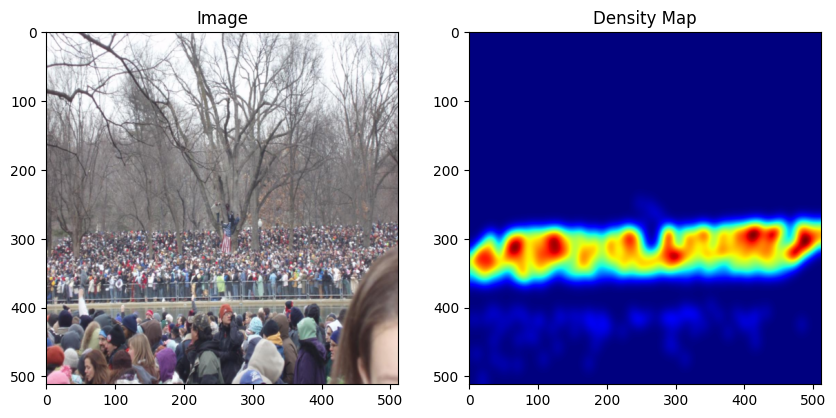

In [4]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import gaussian_filter

class ShanghaiTechDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None, sigma=15):
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.sigma = sigma

        self.image_files = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)


        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        gt_name = f"GT_{os.path.splitext(img_name)[0]}.mat"
        gt_path = os.path.join(self.gt_dir, gt_name)

        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Ground truth file not found: {gt_path}")

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]


        density_map = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
        for point in points:
            x, y = min(int(point[0]), img.shape[1]-1), min(int(point[1]), img.shape[0]-1)
            density_map[y, x] = 1

        density_map = gaussian_filter(density_map, sigma=self.sigma)

        if self.transform:
            img = self.transform(img)

        density_map = cv2.resize(density_map, (img.shape[2], img.shape[1]))
        density_map = torch.tensor(density_map, dtype=torch.float32).unsqueeze(0)
        return img, density_map


def visualize_sample(dataset, idx=0, save_path="visualizations/samplep.png"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    img, gt = dataset[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(gt.squeeze(0), cmap="jet")
    plt.title("Density Map")
    plt.savefig(save_path)
    plt.show()


if __name__ == "__main__":
    image_dir = r"/content/drive/MyDrive/ShanghaiTech/part_A/train_data/images"
    gt_dir = r"/content/drive/MyDrive/ShanghaiTech/part_A/train_data/ground-truth"

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512))
    ])
    dataset = ShanghaiTechDataset(image_dir=image_dir, gt_dir=gt_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    print(f"Total samples: {len(dataset)}")

    visualize_sample(dataset, idx=0)

# **Task-2**

In [5]:
import os, glob, torch, torch.nn as nn, scipy.io as sio
import numpy as np, cv2, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

class CrowdDataset(Dataset):
    def __init__(self, root, train=True, size=(256,256)):
        sub = "train_data" if train else "test_data"
        imgs = sorted(glob.glob(os.path.join(root, sub, "images", ".jpg")) +
                      glob.glob(os.path.join(root, sub, "images", ".png")))
        print(f"[{sub}] Found {len(imgs)} images in {os.path.join(root,sub,'images')}")
        self.imgs = imgs
        self.gts = [p.replace("images","ground-truth").replace(".jpg",".mat").replace(".png",".mat") for p in imgs]
        self.size, self.tf = size, transforms.ToTensor()

    def __len__(self): return len(self.imgs)

    def __getitem__(self, i):
        img=cv2.imread(self.imgs[i]); img=cv2.resize(img,self.size)
        mat=sio.loadmat(self.gts[i])
        pts=mat["image_info"][0,0][0,0][0]
        den=np.zeros(self.size,np.float32)
        for x,y in pts:
            if int(y*self.size[1]/img.shape[0])<self.size[1] and int(x*self.size[0]/img.shape[1])<self.size[0]:
                den[int(y*self.size[1]/img.shape[0]), int(x*self.size[0]/img.shape[1])]=1
        den=cv2.GaussianBlur(den,(15,15),4)
        return self.tf(img), torch.tensor(den).unsqueeze(0)

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg=list(models.vgg16(pretrained=False).features.children())
        self.front=nn.Sequential(*vgg[:23])
        self.back=nn.Sequential(
            nn.Conv2d(512,512,3,1,2,dilation=2),nn.ReLU(),
            nn.Conv2d(512,512,3,1,2,dilation=2),nn.ReLU(),
            nn.Conv2d(512,512,3,1,2,dilation=2),nn.ReLU(),
            nn.Conv2d(512,256,3,1,2,dilation=2),nn.ReLU(),
            nn.Conv2d(256,128,3,1,2,dilation=2),nn.ReLU(),
            nn.Conv2d(128,64,3,1,2,dilation=2),nn.ReLU(),
            nn.Conv2d(64,1,1))
    def forward(self,x): return self.back(self.front(x))


def train_eval(root,epochs=1):
    device="cuda" if torch.cuda.is_available() else "cpu"
    tr=DataLoader(CrowdDataset(root,True),2,shuffle=True)
    te=DataLoader(CrowdDataset(root,False),2,shuffle=False)
    model,lossf,opt=CSRNet().to(device),nn.MSELoss(),torch.optim.Adam(CSRNet().parameters(),1e-5)

    for ep in range(epochs):
        model.train()
        for x,y in tr:
            x,y=x.to(device),y.to(device)
            loss=lossf(model(x),y)
            opt.zero_grad(); loss.backward(); opt.step()
        print(f"Epoch {ep+1} Loss {loss.item():.4f}")


    model.eval()
    x,y=next(iter(te))
    with torch.no_grad(): p=model(x.to(device)).cpu()
    for i in range(min(2,len(x))):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1); plt.imshow(x[i].permute(1,2,0)); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(y[i][0],cmap="jet"); plt.title("GT"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(p[i][0],cmap="jet"); plt.title("Pred"); plt.axis("off")
        plt.show()

import os
root = r"/content/drive/MyDrive/ShanghaiTech/part_B"
for subdir, dirs, files in os.walk(root):
    print(subdir, len(files))

/content/drive/MyDrive/ShanghaiTech/part_B 0
/content/drive/MyDrive/ShanghaiTech/part_B/train_data 0
/content/drive/MyDrive/ShanghaiTech/part_B/train_data/ground-truth 400
/content/drive/MyDrive/ShanghaiTech/part_B/train_data/images 400
/content/drive/MyDrive/ShanghaiTech/part_B/test_data 0
/content/drive/MyDrive/ShanghaiTech/part_B/test_data/images 316
/content/drive/MyDrive/ShanghaiTech/part_B/test_data/ground-truth 316


# **Task-3**

/tmp/ipython-input-1246175346.py:93: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/50:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-1246175346.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1

Ep1 TrLoss=0.0009 ValLoss=0.0004 MAE=707.14 RMSE=825.87


Epoch 2/50: 100%|██████████| 38/38 [00:20<00:00,  1.83it/s, loss=0.000431]


Ep2 TrLoss=0.0005 ValLoss=0.0003 MAE=304.25 RMSE=426.43


Epoch 3/50: 100%|██████████| 38/38 [00:20<00:00,  1.86it/s, loss=0.000232]


Ep3 TrLoss=0.0004 ValLoss=0.0003 MAE=313.76 RMSE=411.65


Epoch 4/50: 100%|██████████| 38/38 [00:21<00:00,  1.79it/s, loss=0.000134]


Ep4 TrLoss=0.0004 ValLoss=0.0003 MAE=303.20 RMSE=396.72


Epoch 5/50: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, loss=8.92e-5]


Ep5 TrLoss=0.0004 ValLoss=0.0002 MAE=292.93 RMSE=381.74


Epoch 6/50: 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, loss=0.000474]


Ep6 TrLoss=0.0004 ValLoss=0.0002 MAE=291.66 RMSE=371.96


Epoch 7/50: 100%|██████████| 38/38 [00:22<00:00,  1.72it/s, loss=0.000209]


Ep7 TrLoss=0.0004 ValLoss=0.0002 MAE=286.43 RMSE=362.49


Epoch 8/50: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s, loss=0.00151]


Ep8 TrLoss=0.0004 ValLoss=0.0002 MAE=293.43 RMSE=361.81


Epoch 9/50: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, loss=0.000688]


Ep9 TrLoss=0.0004 ValLoss=0.0002 MAE=292.01 RMSE=357.50


Epoch 10/50: 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, loss=0.00032]


Ep10 TrLoss=0.0003 ValLoss=0.0002 MAE=291.58 RMSE=354.80


Epoch 11/50: 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, loss=0.000758]


Ep11 TrLoss=0.0003 ValLoss=0.0002 MAE=291.02 RMSE=353.03


Epoch 12/50: 100%|██████████| 38/38 [00:24<00:00,  1.57it/s, loss=0.000255]


Ep12 TrLoss=0.0003 ValLoss=0.0002 MAE=296.21 RMSE=356.41


Epoch 13/50: 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, loss=0.000374]


Ep13 TrLoss=0.0003 ValLoss=0.0002 MAE=270.52 RMSE=337.16


Epoch 14/50: 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, loss=0.000414]


Ep14 TrLoss=0.0003 ValLoss=0.0002 MAE=291.28 RMSE=352.14


Epoch 15/50: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, loss=0.000224]


Ep15 TrLoss=0.0003 ValLoss=0.0002 MAE=288.85 RMSE=350.74


Epoch 16/50: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, loss=0.000142]


Ep16 TrLoss=0.0003 ValLoss=0.0002 MAE=270.03 RMSE=336.27


Epoch 17/50: 100%|██████████| 38/38 [00:21<00:00,  1.74it/s, loss=0.000212]


Ep17 TrLoss=0.0003 ValLoss=0.0002 MAE=288.82 RMSE=351.46


Epoch 18/50: 100%|██████████| 38/38 [00:20<00:00,  1.86it/s, loss=0.000123]


Ep18 TrLoss=0.0003 ValLoss=0.0002 MAE=274.02 RMSE=340.07


Epoch 19/50: 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, loss=0.000473]


Ep19 TrLoss=0.0003 ValLoss=0.0002 MAE=270.19 RMSE=337.49


Epoch 20/50: 100%|██████████| 38/38 [00:21<00:00,  1.77it/s, loss=7.44e-5]


Ep20 TrLoss=0.0003 ValLoss=0.0002 MAE=294.93 RMSE=357.04


Epoch 21/50: 100%|██████████| 38/38 [00:21<00:00,  1.81it/s, loss=0.000253]


Ep21 TrLoss=0.0003 ValLoss=0.0002 MAE=277.77 RMSE=343.14


Epoch 22/50: 100%|██████████| 38/38 [00:21<00:00,  1.79it/s, loss=0.000254]


Ep22 TrLoss=0.0003 ValLoss=0.0002 MAE=305.33 RMSE=366.78


Epoch 23/50: 100%|██████████| 38/38 [00:21<00:00,  1.75it/s, loss=7.02e-5]


Ep23 TrLoss=0.0003 ValLoss=0.0002 MAE=286.79 RMSE=350.55


Epoch 24/50: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, loss=0.000239]


Ep24 TrLoss=0.0003 ValLoss=0.0002 MAE=298.21 RMSE=360.89


Epoch 25/50: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s, loss=0.000277]


Ep25 TrLoss=0.0003 ValLoss=0.0002 MAE=255.97 RMSE=328.16


Epoch 26/50: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s, loss=0.00137]


Ep26 TrLoss=0.0003 ValLoss=0.0002 MAE=276.17 RMSE=342.67


Epoch 27/50: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, loss=0.000841]


Ep27 TrLoss=0.0003 ValLoss=0.0002 MAE=284.88 RMSE=350.04


Epoch 28/50: 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, loss=0.000319]


Ep28 TrLoss=0.0003 ValLoss=0.0002 MAE=277.83 RMSE=344.20


Epoch 29/50: 100%|██████████| 38/38 [00:23<00:00,  1.65it/s, loss=0.00046]


Ep29 TrLoss=0.0003 ValLoss=0.0002 MAE=281.33 RMSE=347.44


Epoch 30/50: 100%|██████████| 38/38 [00:22<00:00,  1.65it/s, loss=5.21e-5]


Ep30 TrLoss=0.0003 ValLoss=0.0002 MAE=251.94 RMSE=324.95


Epoch 31/50: 100%|██████████| 38/38 [00:24<00:00,  1.54it/s, loss=0.000114]


Ep31 TrLoss=0.0003 ValLoss=0.0002 MAE=250.23 RMSE=323.62


Epoch 32/50: 100%|██████████| 38/38 [00:23<00:00,  1.65it/s, loss=0.000103]


Ep32 TrLoss=0.0003 ValLoss=0.0002 MAE=272.23 RMSE=340.17


Epoch 33/50: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s, loss=0.000408]


Ep33 TrLoss=0.0003 ValLoss=0.0002 MAE=274.82 RMSE=342.22


Epoch 34/50: 100%|██████████| 38/38 [00:22<00:00,  1.72it/s, loss=8.17e-5]


Ep34 TrLoss=0.0003 ValLoss=0.0002 MAE=281.19 RMSE=347.62


Epoch 35/50: 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, loss=0.000101]


Ep35 TrLoss=0.0003 ValLoss=0.0002 MAE=252.53 RMSE=324.51


Epoch 36/50: 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, loss=0.000108]


Ep36 TrLoss=0.0003 ValLoss=0.0002 MAE=270.75 RMSE=338.49


Epoch 37/50: 100%|██████████| 38/38 [00:21<00:00,  1.81it/s, loss=0.000116]


Ep37 TrLoss=0.0003 ValLoss=0.0002 MAE=290.96 RMSE=357.11


Epoch 38/50: 100%|██████████| 38/38 [00:21<00:00,  1.73it/s, loss=0.000426]


Ep38 TrLoss=0.0003 ValLoss=0.0002 MAE=266.57 RMSE=334.60


Epoch 39/50: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s, loss=0.000994]


Ep39 TrLoss=0.0003 ValLoss=0.0002 MAE=241.36 RMSE=316.75


Epoch 40/50: 100%|██████████| 38/38 [00:21<00:00,  1.79it/s, loss=4.96e-5]


Ep40 TrLoss=0.0003 ValLoss=0.0002 MAE=274.29 RMSE=341.84


Epoch 41/50: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s, loss=0.00174]


Ep41 TrLoss=0.0003 ValLoss=0.0002 MAE=255.45 RMSE=326.15


Epoch 42/50: 100%|██████████| 38/38 [00:21<00:00,  1.75it/s, loss=7.25e-5]


Ep42 TrLoss=0.0003 ValLoss=0.0002 MAE=265.26 RMSE=334.96


Epoch 43/50: 100%|██████████| 38/38 [00:21<00:00,  1.81it/s, loss=0.000906]


Ep43 TrLoss=0.0003 ValLoss=0.0002 MAE=285.78 RMSE=353.68


Epoch 44/50: 100%|██████████| 38/38 [00:20<00:00,  1.83it/s, loss=0.000159]


Ep44 TrLoss=0.0003 ValLoss=0.0002 MAE=268.21 RMSE=337.80


Epoch 45/50: 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, loss=0.00118]


Ep45 TrLoss=0.0003 ValLoss=0.0002 MAE=295.73 RMSE=365.25


Epoch 46/50: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s, loss=0.00116]


Ep46 TrLoss=0.0003 ValLoss=0.0002 MAE=292.42 RMSE=362.15


Epoch 47/50: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s, loss=6.61e-5]


Ep47 TrLoss=0.0003 ValLoss=0.0002 MAE=296.98 RMSE=367.38


Epoch 48/50: 100%|██████████| 38/38 [00:20<00:00,  1.86it/s, loss=8.85e-5]


Ep48 TrLoss=0.0003 ValLoss=0.0002 MAE=246.95 RMSE=321.22


Epoch 49/50: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s, loss=8.85e-5]


Ep49 TrLoss=0.0003 ValLoss=0.0002 MAE=248.26 RMSE=321.90


Epoch 50/50: 100%|██████████| 38/38 [00:20<00:00,  1.81it/s, loss=7.82e-5]


Ep50 TrLoss=0.0003 ValLoss=0.0002 MAE=254.31 RMSE=327.37


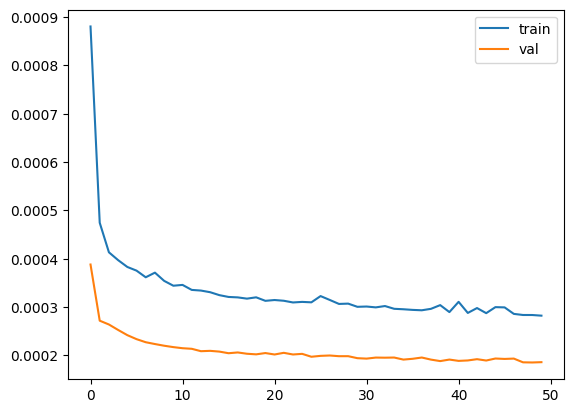

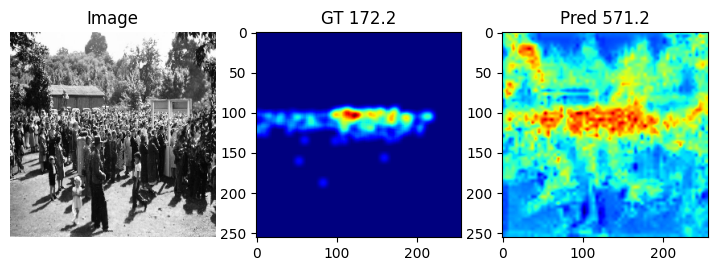

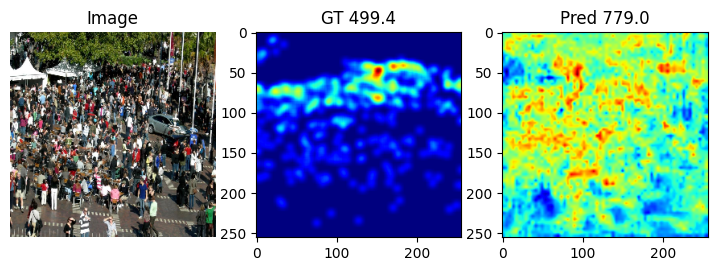

Model saved as tiny_mcnn.pth


In [6]:
import os, glob, cv2, time
import numpy as np, scipy.io as sio, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# --------------------------
# CONFIG
# --------------------------
DATA_ROOT = r"/content/drive/MyDrive/ShanghaiTech/part_A"
IMG_SZ = (256,256)
BATCH = 8
EPOCHS = 50
LR = 1e-5
ALERT_TH = 20.0
SIGMA = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# Dataset
# --------------------------
class CrowdDataset(Dataset):
    def __init__(self, root="", sub="train"):
        self.tf = transforms.ToTensor()
        self.size = IMG_SZ
        img_dir = os.path.join(root, f"{'train_data' if sub=='train' else 'test_data'}","images")
        self.imgs = sorted(glob.glob(os.path.join(img_dir,"*.jpg")) +
                           glob.glob(os.path.join(img_dir,"*.png")))
        if len(self.imgs) == 0:
            raise FileNotFoundError(f"No images found in {img_dir}. Please check path.")
        self.gt_dir = os.path.join(root, f"{'train_data' if sub=='train' else 'test_data'}","ground-truth")

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self,i):
        p=self.imgs[i]
        img=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
        oh,ow=img.shape[:2]
        img=cv2.resize(img,self.size)
        base=os.path.splitext(os.path.basename(p))[0]
        cand = os.path.join(self.gt_dir, f"GT_{base}.mat")
        if not os.path.exists(cand):
            cand = os.path.join(self.gt_dir, base+".mat")
        pts = np.zeros((0,2))
        if os.path.exists(cand):
            m=sio.loadmat(cand)
            try:
                pts = np.array(m["image_info"][0,0][0,0][0],dtype=np.float32)
            except Exception as e:
                print(f"[WARN] Could not parse GT file {cand}: {e}")
        if pts.size:
            pts[:,0] = pts[:,0]* (self.size[1]/ow)
            pts[:,1] = pts[:,1]* (self.size[0]/oh)
        den=np.zeros(self.size,dtype=np.float32)
        for pt in pts:
            x=int(round(pt[0])); y=int(round(pt[1]))
            if 0<=x<self.size[1] and 0<=y<self.size[0]:
                den[y,x]+=1
        den = cv2.GaussianBlur(den,(SIGMA*4+1,SIGMA*4+1),SIGMA) if den.sum()>0 else den
        return self.tf(img.astype('float32')/255.0), torch.from_numpy(den[None]).float()

# --------------------------
# Model: Tiny-MCNN
# --------------------------
class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )
    def forward(self,x):
        o=self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return o

# --------------------------
# Training + Evaluation
# --------------------------
def train_eval(root, epochs=EPOCHS):
    torch.manual_seed(42)
    tr = DataLoader(CrowdDataset(root,'train'), batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
    te = DataLoader(CrowdDataset(root,'test'),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
    model = TinyMCNN().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    lossf = nn.MSELoss()
    scaler = GradScaler()
    train_losses=[]; val_losses=[]
    for ep in range(epochs):
        model.train(); tl=0.0
        pbar = tqdm(tr, desc=f"Epoch {ep+1}/{epochs}")
        for x,y in pbar:
            x,y=x.to(DEVICE, non_blocking=True),y.to(DEVICE, non_blocking=True)
            opt.zero_grad()
            with autocast():
                p=model(x); l=lossf(p,y)
            scaler.scale(l).backward()
            scaler.step(opt)
            scaler.update()
            tl+=l.item()
            pbar.set_postfix(loss=l.item())
        train_losses.append(tl/len(tr) if len(tr)>0 else 0)
        model.eval(); vl=0.0; preds=[]; gts=[]
        with torch.no_grad():
            for x,y in te:
                x,y=x.to(DEVICE, non_blocking=True),y.to(DEVICE, non_blocking=True)
                p=model(x); vl+=lossf(p,y).item()
                preds += p.cpu().numpy().sum(axis=(1,2,3)).tolist()
                gts += y.cpu().numpy().sum(axis=(1,2,3)).tolist()
        val_losses.append(vl/len(te) if len(te)>0 else 0)
        mae = np.mean(np.abs(np.array(preds)-np.array(gts))) if preds else 0
        rmse = (np.mean((np.array(preds)-np.array(gts))**2))**0.5 if preds else 0
        print(f"Ep{ep+1} TrLoss={train_losses[-1]:.4f} ValLoss={val_losses[-1]:.4f} MAE={mae:.2f} RMSE={rmse:.2f}")
    plt.plot(train_losses,label='train'); plt.plot(val_losses,label='val'); plt.legend(); plt.show()
    # visualize predictions
    it=iter(te); shown=0
    with torch.no_grad():
        while shown<2:
            try: x,y = next(it)
            except StopIteration: break
            p = model(x.to(DEVICE)).cpu()
            for i in range(len(x)):
                img=(x[i].permute(1,2,0).numpy()*255).astype('uint8')
                plt.figure(figsize=(9,3))
                plt.subplot(1,3,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
                plt.subplot(1,3,2); plt.imshow(y[i,0],cmap='jet'); plt.title(f'GT {y[i].sum():.1f}')
                plt.subplot(1,3,3); plt.imshow(p[i,0],cmap='jet'); plt.title(f'Pred {p[i].sum():.1f}')
                plt.show(); shown+=1
                if shown>=2: break
    torch.save(model.state_dict(),"tiny_mcnn.pth")
    print("Model saved as tiny_mcnn.pth")
    return model

# --------------------------
# Realtime Inference
# --------------------------
def realtime(model, threshold=ALERT_TH, source=0):
    cap=cv2.VideoCapture(source)
    if not cap.isOpened(): print("Cannot open source"); return
    print("Press q to quit")
    prev=time.time()
    while True:
        ret,frame=cap.read()
        if not ret: break
        h,w=IMG_SZ
        frm=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB); frm=cv2.resize(frm,(w,h))
        t = transforms.ToTensor()(frm.astype('float32')/255.0).unsqueeze(0).to(DEVICE)
        with torch.no_grad(): den = model(t).cpu().squeeze().numpy()
        cnt = den.sum()
        heat = (den/den.max()*255).astype('uint8') if den.max()>0 else np.zeros_like(den,dtype='uint8')
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(cv2.resize(frame,(w,h)),0.6,heat,0.4,0)
        cv2.putText(overlay,f"Count:{cnt:.1f}",(10,25),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2)
        if cnt>threshold: cv2.putText(overlay,"ALERT: OVERCROWD",(10,55),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,255),2)
        fps=1.0/(time.time()-prev); prev=time.time()
        cv2.putText(overlay,f"FPS:{fps:.1f}",(10,85),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,0),2)
        cv2.imshow("Crowd",overlay)
        if cv2.waitKey(1)&0xFF==ord('q'): break
    cap.release(); cv2.destroyAllWindows()

# --------------------------
# MAIN
# --------------------------
if __name__=="__main__":
    model = train_eval(DATA_ROOT, epochs=EPOCHS)

# **Task-4**

In [2]:
%%writefile app_task4.py
import os, smtplib, cv2, torch
import numpy as np
import streamlit as st
from torchvision import transforms
from PIL import Image
from twilio.rest import Client
import torch.nn as nn
import torch.nn.functional as F

IMG_SZ = (256,256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ALERT_THRESHOLD = int(os.getenv("ALERT_THRESHOLD", "150"))

class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )
    def forward(self,x):
        o=self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return o

MODEL_PATH = "/content/tiny_mcnn.pth"
model = TinyMCNN().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
else:
    st.error("❌ Model file not found. Please place tiny_mcnn.pth in app folder.")

def predict_count(img: Image.Image):
    tf = transforms.ToTensor()
    img_resized = img.resize(IMG_SZ)
    t = tf(np.array(img_resized).astype('float32')/255.0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        den = model(t).cpu().squeeze().numpy()
    cnt = float(den.sum())
    return cnt, den

def send_email(subject, body):
    try:
        EMAIL_USER = os.getenv("EMAIL_USER")
        EMAIL_PASS = os.getenv("EMAIL_PASS")
        ALERT_EMAIL = os.getenv("ALERT_EMAIL")
        msg = f"Subject:{subject}\n\n{body}"
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
            smtp.login(EMAIL_USER, EMAIL_PASS)
            smtp.sendmail(EMAIL_USER, ALERT_EMAIL, msg)
        st.success("📧 Email alert sent!")
    except Exception as e:
        st.error(f"Email failed: {e}")

def send_sms(body):
    try:
        TWILIO_SID = os.getenv("TWILIO_SID")
        TWILIO_TOKEN = os.getenv("TWILIO_TOKEN")
        TWILIO_FROM = os.getenv("TWILIO_FROM")
        ALERT_PHONE = os.getenv("ALERT_PHONE")
        client = Client(TWILIO_SID, TWILIO_TOKEN)
        client.messages.create(body=body, from_=TWILIO_FROM, to=ALERT_PHONE)
        st.success("📱 SMS alert sent!")
    except Exception as e:
        st.error(f"SMS failed: {e}")

st.set_page_config(page_title="Crowd Counting Dashboard", layout="wide")
st.title("🧑‍🤝‍🧑 Real-Time Crowd Counting Dashboard")

uploaded = st.file_uploader("Upload a crowd image", type=["jpg","png","jpeg"])
if uploaded:
    img = Image.open(uploaded).convert("RGB")
    st.image(img, caption="Uploaded Image", use_column_width=True)

    count, density = predict_count(img)
    st.metric("Estimated Crowd Count", f"{count:.1f}")
    status = "⚠️ High Crowd!" if count > ALERT_THRESHOLD else "✅ Normal"
    st.metric("Status", status)

    import matplotlib.pyplot as plt
    import io
    fig, ax = plt.subplots()
    ax.imshow(density, cmap="jet")
    ax.set_title("Predicted Density Map")
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    st.image(buf)

    # alert button
    if count > ALERT_THRESHOLD:
        if st.button("🚨 Send Alert"):
            msg = f"Crowd Alert! Count reached {count:.1f}"
            send_email("Crowd Alert", msg)
            send_sms(msg)

Writing app_task4.py


In [3]:
%%writefile app_task4.py
# ====================================================
# Milestone 4: Crowd Counting – Modern Streamlit UI
# ====================================================
import os, smtplib, io, cv2, torch
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from twilio.rest import Client
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------------------------------
# CONFIG
# ----------------------------------------------------
IMG_SZ = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ALERT_THRESHOLD = int(os.getenv("ALERT_THRESHOLD", "150"))

# ----------------------------------------------------
# Model Definition (Tiny-MCNN)
# ----------------------------------------------------
class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )
    def forward(self,x):
        o = self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]),
                              mode='bilinear', align_corners=False)
        return o

# ----------------------------------------------------
# Load trained model
# ----------------------------------------------------
MODEL_PATH = "/content/tiny_mcnn.pth"
model = TinyMCNN().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
else:
    st.error("❌ Model file not found. Please place tiny_mcnn.pth in this folder.")

# ----------------------------------------------------
# Prediction helper
# ----------------------------------------------------
def predict_count(img: Image.Image):
    tf = transforms.ToTensor()
    img_resized = img.resize(IMG_SZ)
    t = tf(np.array(img_resized).astype("float32")/255.0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        den = model(t).cpu().squeeze().numpy()
    return float(den.sum()), den

# ----------------------------------------------------
# Alert helpers
# ----------------------------------------------------
def send_email(subject, body):
    try:
        EMAIL_USER = os.getenv("EMAIL_USER")
        EMAIL_PASS = os.getenv("EMAIL_PASS")
        ALERT_EMAIL = os.getenv("ALERT_EMAIL")
        msg = f"Subject:{subject}\n\n{body}"
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
            smtp.login(EMAIL_USER, EMAIL_PASS)
            smtp.sendmail(EMAIL_USER, ALERT_EMAIL, msg)
        st.success("📧 Email alert sent!")
    except Exception as e:
        st.error(f"Email failed: {e}")

def send_sms(body):
    try:
        TWILIO_SID = os.getenv("TWILIO_SID")
        TWILIO_TOKEN = os.getenv("TWILIO_TOKEN")
        TWILIO_FROM = os.getenv("TWILIO_FROM")
        ALERT_PHONE = os.getenv("ALERT_PHONE")
        client = Client(TWILIO_SID, TWILIO_TOKEN)
        client.messages.create(body=body, from_=TWILIO_FROM, to=ALERT_PHONE)
        st.success("📱 SMS alert sent!")
    except Exception as e:
        st.error(f"SMS failed: {e}")

# ----------------------------------------------------
# Streamlit Page Setup + Custom CSS
# ----------------------------------------------------
st.set_page_config(page_title="Crowd Counting Dashboard",
                   page_icon="👥", layout="wide")
st.markdown("""
<style>
body {background: linear-gradient(120deg,#a1c4fd,#c2e9fb);}
h1, h2, h3 {color: #0f2027;}
.stMetric {background: rgba(255,255,255,0.7); border-radius:12px;}
footer {visibility: hidden;}
</style>
""", unsafe_allow_html=True)

st.title("👥 Crowd Counting & Alert System")

# Sidebar
with st.sidebar:
    st.header("⚙️ Settings")
    ALERT_THRESHOLD = st.slider("Alert Threshold", 10, 500, ALERT_THRESHOLD)
    st.markdown("Upload an image of a crowd and get the estimated count. "
                "If the count exceeds the threshold, send email/SMS alerts.")

# ----------------------------------------------------
# Main Layout
# ----------------------------------------------------
col1, col2 = st.columns([1.2, 1])

uploaded = st.file_uploader("📂 Upload a crowd image",
                            type=["jpg","jpeg","png"])
if uploaded:
    img = Image.open(uploaded).convert("RGB")
    with col1:
        st.image(img, caption="Uploaded Image", use_column_width=True)

    # Prediction
    count, density = predict_count(img)

    with col2:
        st.subheader("📊 Prediction")
        st.metric("Estimated Crowd Count", f"{count:.1f}",
                  delta=None, delta_color="inverse")
        status = "⚠️ **High Crowd!**" if count > ALERT_THRESHOLD else "✅ Normal"
        st.markdown(f"### Status: {status}")

        # Density heatmap
        fig, ax = plt.subplots()
        ax.imshow(density, cmap="plasma")
        ax.axis("off")
        st.pyplot(fig, clear_figure=True)

        # Alert controls
        if count > ALERT_THRESHOLD:
            st.markdown("---")
            st.warning("Crowd exceeds threshold!")
            if st.button("🚨 Send Alert"):
                msg = f"Crowd Alert! Estimated count: {count:.1f}"
                send_email("Crowd Alert", msg)
                send_sms(msg)
else:
    st.info("⬆️ Upload a crowd photo to start analysis.")


Overwriting app_task4.py


In [ ]:
!pip install --upgrade importlib-metadata

In [4]:
import os
os.environ["TWILIO_SID"] = "AC189f89505127fdce1c5db74f984f9253"
os.environ["TWILIO_TOKEN"] = "0bfd5170191008230b5c2a39a45907a4"
os.environ["TWILIO_FROM"] = "+12765000842"
os.environ["ALERT_PHONE"] = "+919014102766"

os.environ["EMAIL_USER"] = "kalyanguguloth1215@gmail.com"
os.environ["EMAIL_PASS"] = "trmueryjbhmrfqum"
os.environ["ALERT_EMAIL"] = "kalyanguguloth1405@gmail.com"

os.environ["NGROK_AUTH_TOKEN"] = "32s7nuXCLY3VB3eaP6g9BpTpuuZ_4NjeQwsYx8eZV9LagyLft"

In [5]:
from pyngrok import ngrok
import time
# set ngrok auth
ngrok.set_auth_token(os.environ["NGROK_AUTH_TOKEN"])
ngrok.kill()
# start streamlit
get_ipython().system_raw("streamlit run app_task4.py --server.port 8501 --server.address 0.0.0.0 &")
time.sleep(3)
public_url = ngrok.connect(8501)
print("🌍 Open this link:", public_url)

🌍 Open this link: NgrokTunnel: "https://09f0a9e84828.ngrok-free.app" -> "http://localhost:8501"
